In [3]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col,sum
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.types import DateType
from pyspark.sql.functions import split
from pyspark.sql import Window
from pyspark.sql.functions import regexp_extract, col
from pyspark.sql.functions import *

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession \
    .builder \
    .appName("Sparkify_project_new") \
    .getOrCreate()

In [5]:
spark

In [6]:
def load_data(filename):
    
    '''
    Funtion to load data and remove null, empty strings.
    INPUT
    filename = name of file as well the path
    OUTPUT
    df - a spark dataframe with no null rows for primary key
    '''
    
    df = spark.read.json(filename)
    
    
    print('\n Data Set loaded Succesfully')
    print("\n Count of rows in dataframe: {}".format(df.count()))
    
    return df

In [7]:
path = "mini_sparkify_event_data.json"
df = load_data(path)


 Data Set loaded Succesfully

 Count of rows in dataframe: 286500


In [8]:
print(df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

None


In [9]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [10]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

## Removing the Missing values

In [11]:
def remove_na(df):
    
    print("Removing the NA Values in the dataset ")
    print("-"*115)
    print("\n The size of the Data set before removing NA:",df.count())
    
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df = df.filter(df["userId"] != "")
    
    print("\n The size of the Data set after removing NA:",df.count())
    
    print("\n Updated Table after removing the NA Values ")
    print("-"*115)
    
    df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show() 
    print("-"*115)
    
    return df

In [12]:
df = remove_na(df)

Removing the NA Values in the dataset 
-------------------------------------------------------------------------------------------------------------------

 The size of the Data set before removing NA: 286500

 The size of the Data set after removing NA: 278154

 Updated Table after removing the NA Values 
-------------------------------------------------------------------------------------------------------------------
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|    

## Some Basic Explorations

In [13]:
def add_date_columns(df):
    '''
    Funtion to add date/time related columns to the dataframe.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with calculated fields: hour, month, year, day
    '''
    # create a function to get hour, month, year, day from timestamp
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
    get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
    get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
    
    
    # add hour, month, year, day, date columns to the dataframe
    df = df.withColumn("hour", get_hour(df.ts))
    df = df.withColumn("month", get_month(df.ts))
    df = df.withColumn("year", get_year(df.ts))
    df = df.withColumn("day", get_day(df.ts))
    df = df.withColumn("date", from_unixtime(df.ts/1000).cast(DateType()))
    
    #df_test2.withColumn('date_again', func.from_unixtime('timestamp').cast(DateType()))
    
    
    return df

In [14]:
df = add_date_columns(df)

In [15]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', month='10', year='2018', day='1', date=datetime.date(2018, 10, 1))

In [16]:
print(df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- day: string (nullable = true)
 |-- date: date (nullable = true)

None


In [17]:
def get_hour_stats(df):
    
    '''
    Funtion to load data and plot the scatter plot for hour by hour stats.
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a scatter plot from matplotlib
    '''
    
    songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
    songs_in_hour_pd = songs_in_hour.toPandas()
    songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)
    
    
    plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
    plt.xlim(-1, 24);
    plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
    plt.xlabel("Hour")
    plt.ylabel("Songs played");

AttributeError: 'numpy.int64' object has no attribute '_get_object_id'

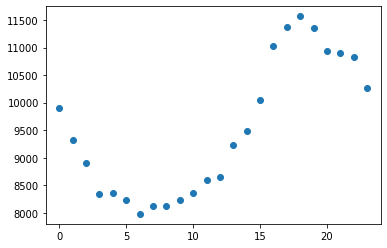

In [18]:
get_hour_stats(df)

In [19]:
unique_users = df.select('userId','level','gender','location').distinct()

print("\n The Number of Unique Users in the Data Set is:",unique_users.count())


 The Number of Unique Users in the Data Set is: 360


In [20]:
def plot_gender_stats(data):
    
    '''
    Funtion to load data and plot the bar plot for user gender stats.
    
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a bar plot from matplotlib
    '''
    
    gender_count = df.groupby('gender').count().toPandas()
    gender_count.set_index('gender',inplace = True)
    gender_count
    
    
    gender_count.plot(kind='bar',figsize=(10,5))
    plt.title('Gender Comparison',fontsize = 15)
    plt.ylabel('Count',fontsize = 15)
    plt.xlabel('Gender',fontsize = 15)
    plt.xticks(fontsize = 15,rotation = 45);
    
    
def plot_level_stats(data):
    
    '''
    Funtion to load data and plot the bar plot for user level stats.
    
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a bar plot from matplotlib
    '''
    
    unique_users_level = df.groupby('level').count().toPandas()
    unique_users_level.set_index('level',inplace = True)
    unique_users_level
    
    unique_users_level.plot(kind='bar',figsize=(10,5))
    plt.title('Account Type comparison',fontsize = 15)
    plt.ylabel('Count',fontsize = 15)
    plt.xlabel('Account type',fontsize = 15)
    plt.xticks(fontsize = 15,rotation = 45);
    
def most_played_artist(data):
    
    '''
    Funtion to load data and plot the bar plot for most played stats.
    
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a bar plot from matplotlib
    '''
    
    most_played_artist = df.filter(df.page == 'NextSong').select('Artist').groupBy('Artist').count().toPandas()
    most_played_artist = most_played_artist.sort_values(by=['count'],ascending = False).head(10)
    
    sns.barplot('Artist', 'count', data= most_played_artist)
    plt.title('Top 10 Artists')
    plt.xticks(rotation = 90);
    
def most_played_song(data):
    
    
    '''
    Funtion to load data and plot the bar plot for most played stats.
    
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a bar plot from matplotlib
    '''
    
    most_played_song = df.filter(df.page == 'NextSong').select('song').groupBy('song').count().toPandas()
    most_played_song = most_played_song.sort_values(by=['count'],ascending = False).head(10)
    
    sns.barplot('song', 'count', data= most_played_song)
    plt.title('Top 10 songs')
    plt.xticks(rotation = 90); 

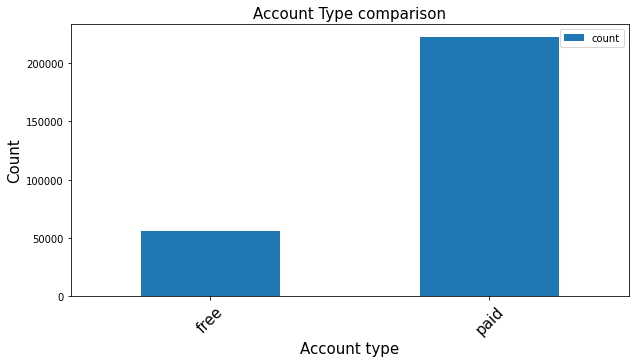

In [21]:
plot_level_stats(df)

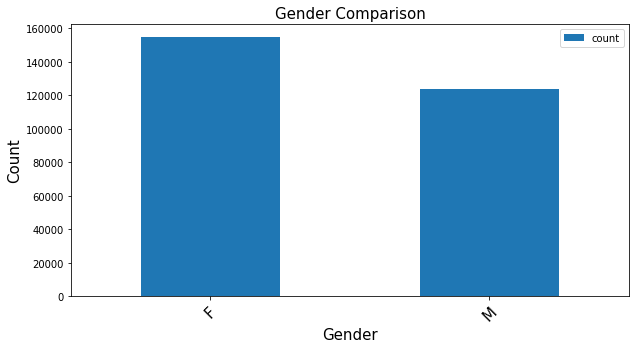

In [22]:
plot_gender_stats(df)

/Users/shreeraamalagarsamysethuraj/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/shreeraamalagarsamysethuraj/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


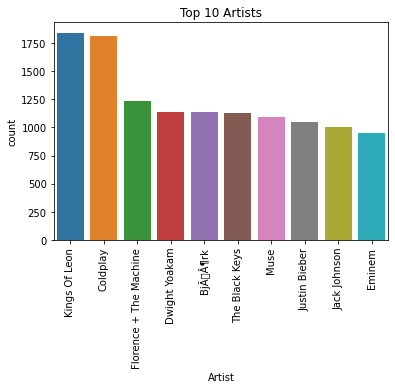

In [23]:
most_played_artist(df)

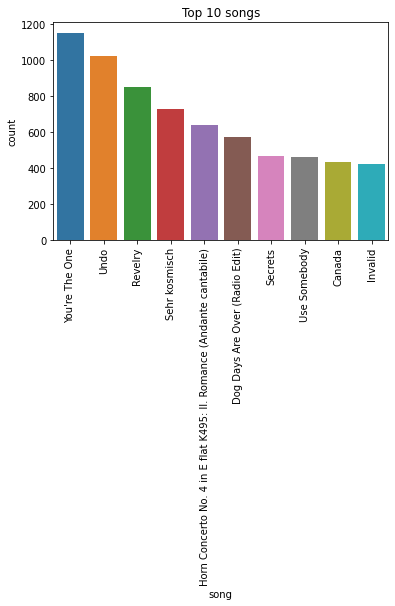

In [24]:
most_played_song(df)

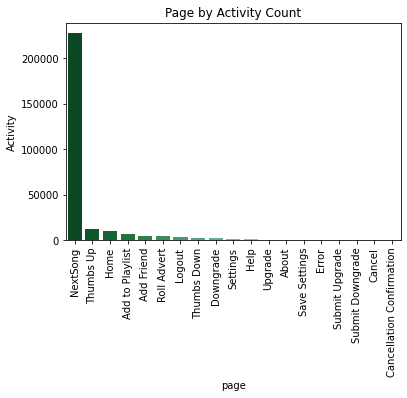

In [25]:
activity = df.select('page')\
.groupBy('page')\
.agg({'page': 'count'})\
.sort(desc('count(page)')).withColumnRenamed('count(page)', 'Activity')\
.toPandas()

sns.barplot('page', 'Activity', data= activity, palette = 'BuGn_r')
plt.title('Page by Activity Count')
plt.xticks(rotation = 90);

In [26]:
churn_flag = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('isChurn', churn_flag('page'))

In [27]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("isChurn", Fsum("isChurn").over(windowval))

In [28]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



### Churn Distribution

In [29]:
df_distinct = df.dropDuplicates(['userId'])

In [30]:
churn_distribution_1 = df_distinct.groupby('isChurn').count().toPandas()

In [31]:
churn_distribution_1

,isChurn,count
0,0,173
1,1,52


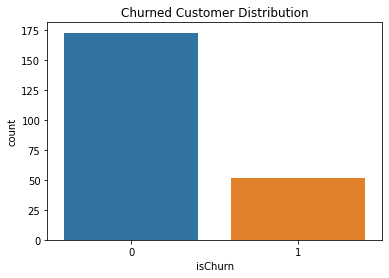

In [32]:
sns.barplot('isChurn', 'count', data= churn_distribution_1)
plt.title('Churned Customer Distribution');

### Gender Distribution

In [33]:
gender_dist = df_distinct.groupBy("gender", "isChurn").count().toPandas()

In [34]:
gender_dist

,gender,isChurn,count
0,F,0,84
1,F,1,20
2,M,0,89
3,M,1,32


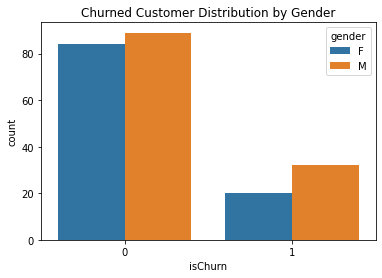

In [35]:
sns.barplot('isChurn', 'count', hue = 'gender', data= gender_dist)
plt.title('Churned Customer Distribution by Gender');

### Average Skipped Songs

In [36]:
def avg_skipped_songs(data):
    
    '''
    Funtion to load data and plot the bar plot for average skipped songs.
    
    INPUT
    filename = data - a spark dataframe
    OUTPUT
    df - a bar plot from seaborn
    
    '''
        
    
    skipped_songs = data.where(data['page'] == 'NextSong').groupby('isChurn').count().toPandas()
    skipped_songs[['count']] = skipped_songs[['count']].div(df_distinct.count(),axis=0)
    sns.barplot('isChurn', 'count', data= skipped_songs)
    plt.title('Avg. Skipped Songs by Customer Type');  

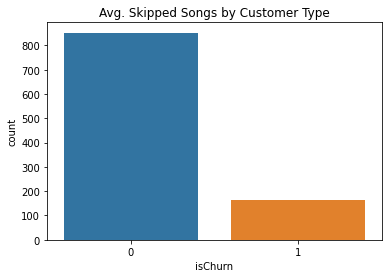

In [37]:
avg_skipped_songs(df)

In [38]:
def avg_thumbs_down(data):
    
    '''
    Funtion to load data and plot the bar plot for average skipped songs.
    
    INPUT
    filename = data - a spark dataframe
    OUTPUT
    df - a bar plot from seaborn
    
    '''
        
    
    thumbs_down = data.where(data['page'] == 'Thumbs Down').groupby('isChurn').count().toPandas()
    thumbs_down[['count']] = thumbs_down[['count']].div(df_distinct.count(),axis=0)
    sns.barplot('isChurn', 'count', data= thumbs_down)
    plt.title('Avg.thumbs_down by Customer Type');  

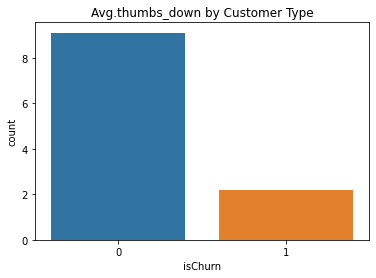

In [39]:
avg_thumbs_down(df)

In [40]:
def avg_additions_playlist(data):
    
    '''
    Funtion to load data and plot the bar plot for average skipped songs.
    
    INPUT
    filename = data - a spark dataframe
    OUTPUT
    df - a bar plot from seaborn
    
    '''
        
    
    thumbs_down = data.where(data['page'] == 'Add to Playlist').groupby('isChurn').count().toPandas()
    thumbs_down[['count']] = thumbs_down[['count']].div(df_distinct.count(),axis=0)
    sns.barplot('isChurn', 'count', data= thumbs_down)
    plt.title('Avg.thumbs_down by Customer Type'); 

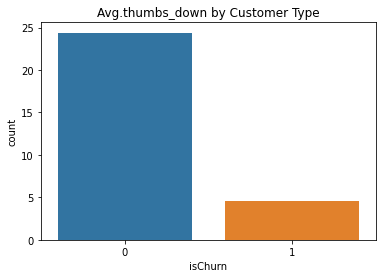

In [41]:
avg_additions_playlist(df)

In [42]:
def avg_friends_added(data):
    
    '''
    Funtion to load data and plot the bar plot for average skipped songs.
    
    INPUT
    filename = data - a spark dataframe
    OUTPUT
    df - a bar plot from seaborn
    
    '''
        
    
    thumbs_down = data.where(data['page'] == 'Add Friend').groupby('isChurn').count().toPandas()
    thumbs_down[['count']] = thumbs_down[['count']].div(df_distinct.count(),axis=0)
    sns.barplot('isChurn', 'count', data= thumbs_down)
    plt.title('Avg.thumbs_down by Customer Type'); 

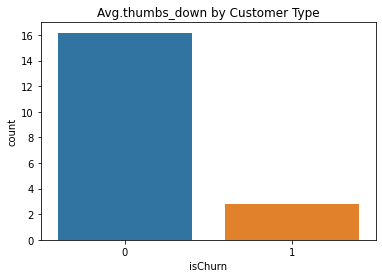

In [43]:
avg_friends_added(df)

In [44]:
df

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string, hour: string, month: string, year: string, day: string, date: date, isChurn: bigint]

### Average Session time.

In [45]:
def average_session(data):
    
    
    '''
    Funtion to load data and plot the bar plot for average skipped songs.
    
    INPUT
    filename = data - a spark dataframe
    OUTPUT
    df - a bar plot from seaborn
    
    '''
    
    churn_session_length = df.groupBy("isChurn")
    churn_session_length  = churn_session_length.agg({'hour':'avg'}).toPandas()
    sns.barplot('isChurn', 'avg(hour)', data= churn_session_length)
    plt.title('Avg.Session'); 

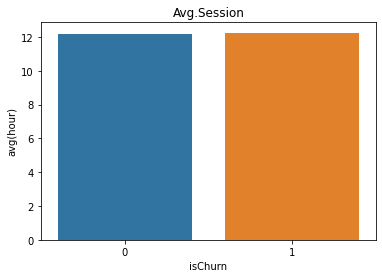

In [46]:
average_session(df)

### Feature Engineering

In [47]:
def create_page_features(df):
    
    """ Creates features based on several of the values from the page variable
    
    Args:
    df: Spark Dataframe
    
    Returns:
    page_features: list of Spark Dataframes with page counts
    """
    
    pages = ['Next Song', 'Add Friend', 'Thumbs Up', 'Thumbs Down', 'Add to Playlist']
    renamed_columns = ['skippedSongs', 'friendsAdded', 'thumbsUp', 'thumbsDown', 'playlistAdditions']
    page_features = []
    
    for page, renamed_col in zip(pages , renamed_columns):
        var = df.select('userId', 'page')\
        .groupby('userId', 'page')\
        .agg({'page' : 'count'})\
        .filter(df.page == page)\
        .withColumnRenamed('count(page)', renamed_col)
        page_features.append(var)
        
    return page_features

In [48]:
create_page_features(df)

[DataFrame[userId: string, page: string, skippedSongs: bigint],
 DataFrame[userId: string, page: string, friendsAdded: bigint],
 DataFrame[userId: string, page: string, thumbsUp: bigint],
 DataFrame[userId: string, page: string, thumbsDown: bigint],
 DataFrame[userId: string, page: string, playlistAdditions: bigint]]

In [49]:
def create_features(df):
    """ Creates all features for modelling and returns a new dataframe with each unique user as an instance
    Args:
    df: Spark dataframe with raw data
    
    Return:
    engineered_df: Spark dataframe with unique users and their engineered features showcasing user behavior
    """
    
    # Create gender feature
    male_flag = udf(lambda x: 1 if x == 'M' else 0, IntegerType())
    df = df.withColumn('isMale', male_flag('gender'))
    
    # Create page features
    features = create_page_features(df)
    
    # Count total sessions
    sessions = df.select('userId', 'sessionId').\
    groupBy('userId').\
    agg({'sessionId': 'count'}).\
    withColumnRenamed('count(sessionId)', 'totalSessions')
    
    # Sum total Length
    total_length = df.select('userId', 'length').\
    groupBy('userId').\
    agg({'length': 'sum'}).\
    withColumnRenamed('sum(length)', 'totalLength')
    
    # Put all features together
    features.extend([sessions, total_length])
    
    for i in features:
        df = df.join(i, on = ['userId'], how = 'outer')
    
    engineered_df = df.select('userId', 'isChurn', 'isMale', 'thumbsUp', 'thumbsDown', 'playlistAdditions', 
          'totalSessions', 'totalLength', 'friendsAdded', 'skippedSongs').dropDuplicates()

    return engineered_df

In [50]:
create_features(df)

DataFrame[userId: string, isChurn: bigint, isMale: int, thumbsUp: bigint, thumbsDown: bigint, playlistAdditions: bigint, totalSessions: bigint, totalLength: double, friendsAdded: bigint, skippedSongs: bigint]

In [51]:
new_df = create_features(df)
new_df = new_df.fillna(0)

In [55]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

In [56]:
# https://stackoverflow.com/questions/40337744/scalenormalise-a-column-in-spark-dataframe-pyspark
for i in ['thumbsUp', 'thumbsDown', 'playlistAdditions', 'totalSessions', 'totalLength', 'friendsAdded', 'skippedSongs']:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    new_df = pipeline.fit(new_df).transform(new_df).drop(i+"_Vect")

In [57]:
all_feat_assembler = VectorAssembler(inputCols=['thumbsUp_Scaled', 'thumbsDown_Scaled', 'playlistAdditions_Scaled', 
                                                'totalSessions_Scaled', 'totalLength_Scaled', 'friendsAdded_Scaled', 
                                                'skippedSongs_Scaled','isMale'],outputCol="features")
new_df = all_feat_assembler.transform(new_df)

### Modeling


Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [58]:
new_df = new_df.select(new_df['isChurn'].alias('label'),new_df['features'])

In [59]:
train, test = new_df.randomSplit([0.7, 0.3], seed = 42)
sub_test, validation = test.randomSplit([0.5, 0.5], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 167
Test Dataset Count: 58


In [73]:
rf_clf = RandomForestClassifier()
rf_fitted_model = rf_clf.fit(train)
evaluator =  MulticlassClassificationEvaluator(metricName = 'f1')
predictions = rf_fitted_model.transform(test)
f1_score = evaluator.evaluate(predictions)
print('Random Forest F1-Score: {}'.format(f1_score*100,2))

Random Forest F1-Score: 70.15915119363395


In [74]:
gbt_clf = GBTClassifier(featuresCol = 'features', labelCol = "label", maxIter = 10, maxDepth = 10, seed = 42)
gbt_fitted_model = gbt_clf.fit(train)
predictions = gbt_fitted_model.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
gbt_f1_score = evaluator.evaluate(predictions)
print('GBT F1-Score: {}'.format(gbt_f1_score*100,2))

GBT F1-Score: 73.16828765104627


In [75]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.01)
lr_fitted_model = lr.fit(train)
predictions = lr_fitted_model.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
lr_f1_score = evaluator.evaluate(predictions)
print('Logistic Regression F1-Score: {}'.format(lr_f1_score*100,2))

Logistic Regression F1-Score: 70.15915119363395


In [76]:
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=10, regParam=0.1)
svm_fitted_model = svm.fit(train)
predictions = svm_fitted_model.transform(test)
evaluator = MulticlassClassificationEvaluator(metricName = 'f1')
svm_f1_score = evaluator.evaluate(predictions)
print('SVM F1-Score: {}'.format(svm_f1_score*100,2))

SVM F1-Score: 70.15915119363395


### Hyperparameter tuning with Random Forest

In [77]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

paramGrid = ParamGridBuilder().\
            addGrid(rf.numTrees, [10, 20, 30]).\
            build()

cross_val_rf = CrossValidator(estimator = gbt_clf, estimatorParamMaps = paramGrid, 
                              evaluator = MulticlassClassificationEvaluator(metricName = 'f1'), numFolds = 5)

In [ ]:
rf_model = cross_val_rf.fit(train)